In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import cv2
import time
import os
from IDMCarFollowing import *
# times new roman font for matplotlib
plt.rcParams["font.family"] = "Times New Roman"

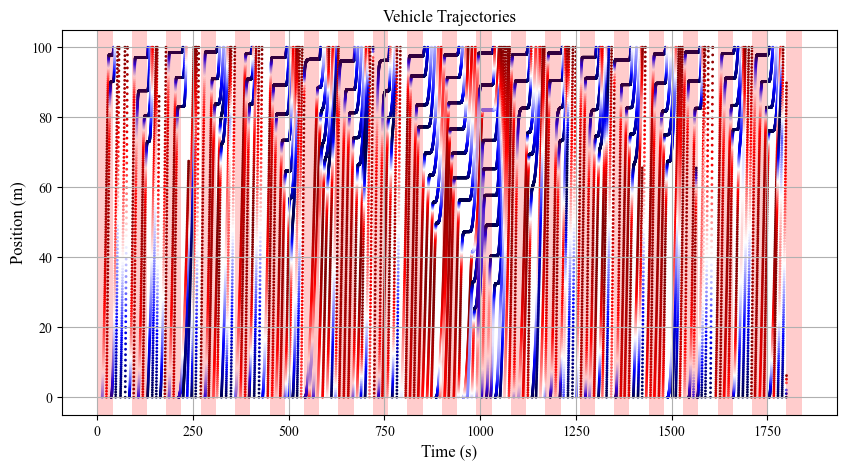

In [2]:

# Run simulation
lane_length = 100  # meters
simulation_time = 1800  # seconds
delta_t = 0.1  # seconds

red_light_time = 40
green_light_time = 50



mean_headway = 11.5
mean_speed = 5 
lane_change_prob = 0.06
vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob )
total_vehicles = vehicles + exited_vehicles

# Plotting, use color to represent speed
plt.figure(figsize=(10, 5))
for vehicle in total_vehicles:
    plt.scatter(vehicle.history_t, vehicle.history_x, c=vehicle.history_v, cmap='seismic', s=1)

plt.title('Vehicle Trajectories')
plt.xlabel('Time (s)',fontsize = 12)
plt.ylabel('Position (m)',fontsize = 12)
plt.grid(True)

# Add traffic light cycle visualization
for i in range(int(simulation_time / (red_light_time + green_light_time)) + 1):
    plt.axvspan(i * (red_light_time + green_light_time), (i * (red_light_time + green_light_time)) + red_light_time, 
                facecolor='red', alpha=0.2)
# plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Dissertation\Figures\Simulation\Vehicle_Trajectories_4050sec_headway_11.png')
plt.show()
# # plot queue length curve
# plt.figure(figsize=(12, 6))
# plt.plot(range(len(queue_record)), queue_record)
# plt.title('Queue Length')
# plt.xlabel('Time (s)')
# plt.ylabel('Number of Vehicles')
# plt.grid(True)
# plt.show()
# speed_profile = []
# for vehicle in total_vehicles:
#     speed_profile.append(vehicle.history_v)
# speed_profile = np.concatenate(speed_profile)
# # plot distribution of speed
# plt.figure(figsize=(12, 6))
# plt.hist(speed_profile, bins=50, density=True, alpha=0.6, color='g')
# plt.title('Speed Distribution')
# plt.xlabel('Speed (m/s)')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()


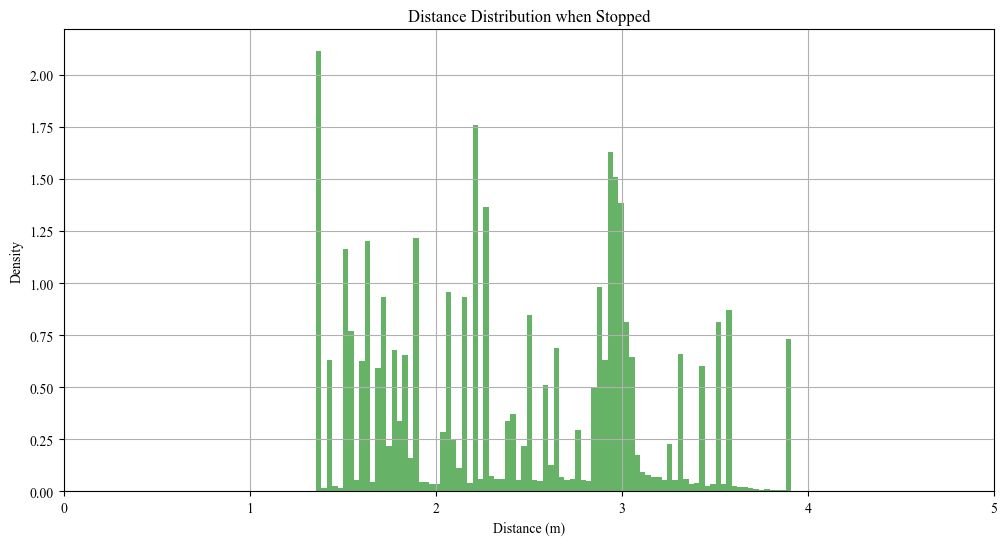

In [3]:
# plot s distribution when stoppped
s_profile = []
v_profile = []
for vehicle in total_vehicles:
    s_profile.append(vehicle.history_s)
    v_profile.append(vehicle.history_v)

s_profile = np.concatenate(s_profile)
v_profile = np.concatenate(v_profile)
s_profile = s_profile[v_profile == 0]
# exclude 10000
s_profile = s_profile[s_profile != 10000]
plt.figure(figsize=(12, 6))
plt.hist(s_profile, bins=3000, density=True, alpha=0.6, color='g')
plt.title('Distance Distribution when Stopped')
plt.xlabel('Distance (m)')
plt.ylabel('Density')
plt.xlim(0, 5)
plt.grid(True)
plt.show()

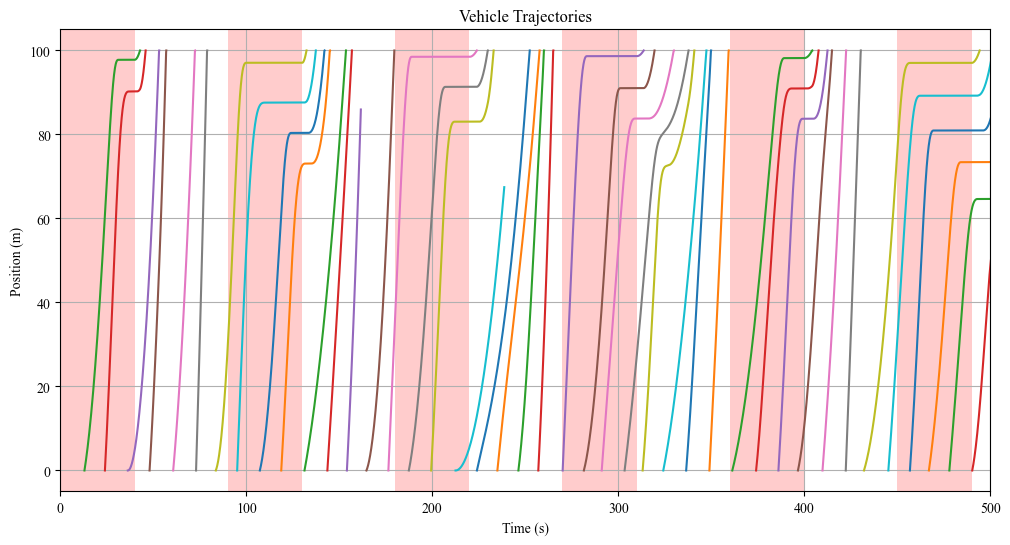

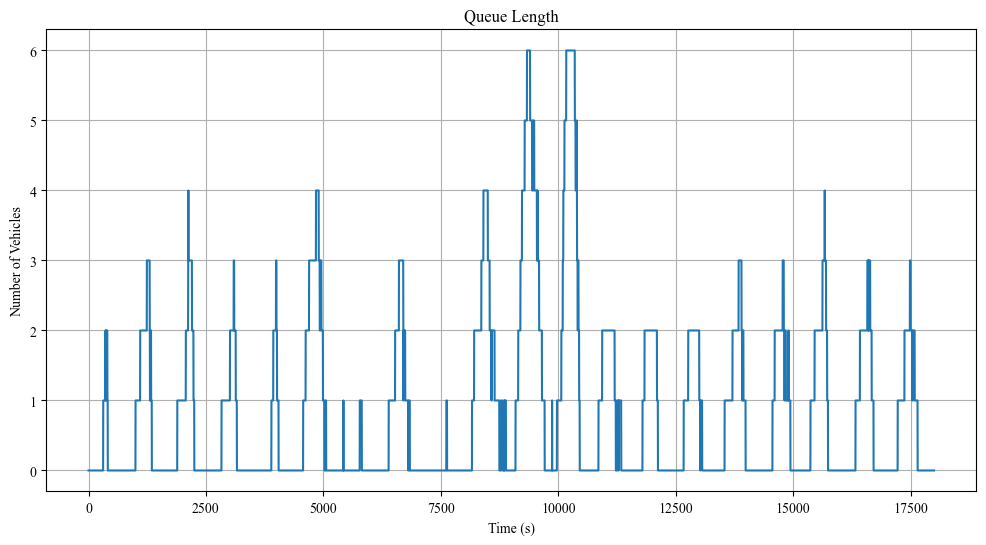

In [4]:

# Plotting
plt.figure(figsize=(12, 6))
for vehicle in vehicles + exited_vehicles:
    plt.plot(vehicle.history_t, vehicle.history_x)

plt.title('Vehicle Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.grid(True)

# Add traffic light cycle visualization
for i in range(int(simulation_time / (red_light_time + green_light_time)) + 1):
    plt.axvspan(i * (red_light_time + green_light_time), (i * (red_light_time + green_light_time)) + red_light_time, 
                facecolor='red', alpha=0.2)
plt.xlim(0, 500)
plt.show()
# plot queue length curve
plt.figure(figsize=(12, 6))
plt.plot(range(len(queue_record)), queue_record)
plt.title('Queue Length')
plt.xlabel('Time (s)')
plt.ylabel('Number of Vehicles')
plt.grid(True)
# plt.xlim(0, 500)
plt.show()
# speed_profile = []
# for vehicle in total_vehicles:
#     speed_profile.append(vehicle.history_v)
# speed_profile = np.concatenate(speed_profile)
# # plot distribution of speed
# plt.figure(figsize=(12, 6))
# plt.hist(speed_profile, bins=50, density=True, alpha=0.6, color='g')
# plt.title('Speed Distribution')
# plt.xlabel('Speed (m/s)')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()

In [5]:

# After running the simulation
time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(vehicles + exited_vehicles, lane_length, simulation_time, delta_t,0.5)

In [6]:
# upside down the grid
time_space_mask = np.flipud(time_space_mask)
time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
noised = add_noise(occluded_diagram)

speed_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
speed_mask = np.flipud(speed_mask)
speed_mask = speed_mask.astype(np.float16)

track_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    track_mask[vehicle[2],vehicle[1]] = 1
track_mask = np.flipud(track_mask)
track_mask = track_mask.astype(np.uint8)
v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
for vehicle in vehicle_trajs:
    v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
v_id_mask = np.flipud(v_id_mask)
v_id_mask = v_id_mask.astype(np.int16)

In [7]:
red_light_time_start_timestamps = np.arange(0, simulation_time, red_light_time + green_light_time)
red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time

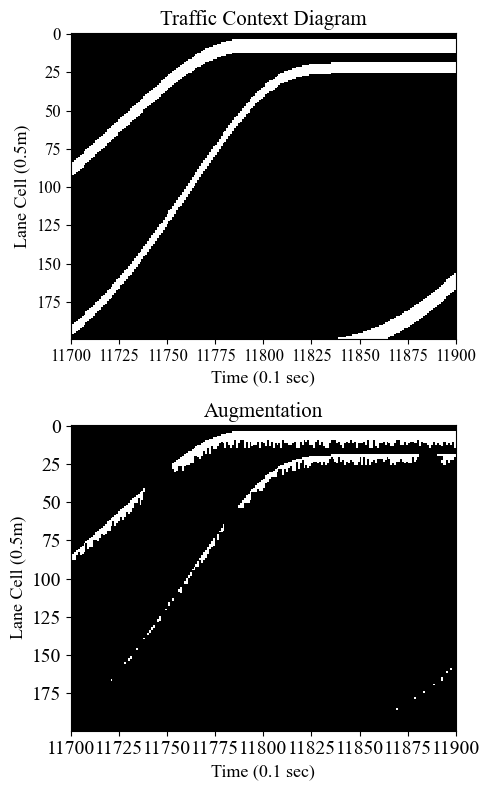

In [9]:
# set times new roman font
plt.rcParams["font.family"] = "Times New Roman"
# raw time-space diagram, occluded_diagram, noised, 3x1 grid
start_frame = red_light_time_start_timestamps[13] * 10
end_frame = start_frame + 200
plt.figure(figsize=(5, 8))
plt.subplot(2, 1, 1)
plt.imshow(time_space_mask, cmap='gray', aspect='auto', interpolation='none')
plt.title('Traffic Context Diagram', fontsize=15)
plt.xlabel('Time (0.1 sec)', fontsize=13)
plt.ylabel('Lane Cell (0.5m)', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([start_frame, end_frame])
# plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(occluded_diagram, cmap='gray', aspect='auto', interpolation='none')
plt.title('Augmentation', fontsize=15)
plt.xlabel('Time (0.1 sec)', fontsize=13)
plt.ylabel('Lane Cell (0.5m)', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([start_frame, end_frame])

# # plt.colorbar()
# plt.subplot(3, 1, 3)
# plt.imshow(noised, cmap='gray', aspect='auto', interpolation='none')
# plt.title('Noised Applied', fontsize=20)
# plt.xlabel('Time (0.1 sec)', fontsize=16)
# plt.ylabel('Lane Unit Index', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlim([start_frame, end_frame])

# plt.colorbar()
plt.tight_layout()
# plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DataAugmentation.png', dpi = 300)
plt.show()


In [10]:
# Run simulation
lane_length = 100  # meters
simulation_time = 1800  # seconds
delta_t = 0.1  # seconds

red_light_time = 35
green_light_time = 35
mean_headway = 8
mean_speed = 10 
lane_change_prob = 0.06

In [54]:
from tqdm import tqdm

out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
target_folder = os.path.join(out_folder, 'target')
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
if not os.path.exists(post_occ_label_folder):
    os.makedirs(post_occ_label_folder)
speed_label_folder = os.path.join(out_folder, 'speed_label')
if not os.path.exists(speed_label_folder):
    os.makedirs(speed_label_folder)
traj_id_label_folder = os.path.join(out_folder, 'traj_id_label')
if not os.path.exists(traj_id_label_folder):
    os.makedirs(traj_id_label_folder)

delta_t = 0.1  # seconds
delta_x = 0.5  # meters
lane_length = 100  # meters
past_frames = 100
pred_frames = 100
simulation_repeat = 0
lane_change_prob = 0.1
total_sampled_flow_status = []
simulation_history = []
red_light_time = 35 + np.random.randint(-5, 5)
green_light_time = 40 + np.random.randint(-5, 5)
for rep in tqdm(range(30000)):
    simulation_time = 15 * (red_light_time + green_light_time)  # seconds: 2 cycles
    mean_headway = 10 + np.random.normal(0,2) # seconds
    if mean_headway < 5:
        mean_headway = 5
    mean_speed = 10 + np.random.normal(0,4)# m/s
    if mean_speed < 5:
        mean_speed = 5
    vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob)

    total_vehicles = vehicles + exited_vehicles
    # After running the simulation
    time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t,delta_x)
    # upside down the grid
    time_space_mask = np.flipud(time_space_mask)
    time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
    occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
    noised = add_noise(occluded_diagram)

    speed_mask = np.zeros((time_space_mask.shape))
    for vehicle in vehicle_trajs:
        speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
    speed_mask = np.flipud(speed_mask)
    speed_mask = speed_mask.astype(np.float16)

    track_mask = np.zeros((time_space_mask.shape))
    for vehicle in vehicle_trajs:
        track_mask[vehicle[2],vehicle[1]] = 1
    track_mask = np.flipud(track_mask)
    track_mask = track_mask.astype(np.uint8)
    v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
    for vehicle in vehicle_trajs:
        v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
    v_id_mask = np.flipud(v_id_mask)
    v_id_mask = v_id_mask.astype(np.int16)

    np.save(os.path.join(target_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), track_mask)
    np.save(os.path.join(post_occ_label_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), noised)
    np.save(os.path.join(speed_label_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), speed_mask)
    np.save(os.path.join(traj_id_label_folder, f'{red_light_time}_{green_light_time}_{rep}_signal.npy'), v_id_mask)
    
# # free flow simulation 
# for rep in tqdm(range(15000)):
#     simulation_time = 120
#     mean_headway = 15
#     mean_speed = 8 + np.random.rand() * 22
#     red_light_time = 0
#     green_light_time = 45
#     vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob)

#     total_vehicles = vehicles + exited_vehicles
#     # After running the simulation
#     time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t,delta_x)
#     # upside down the grid
#     time_space_mask = np.flipud(time_space_mask)
#     time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
#     occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
#     noised = add_noise(occluded_diagram)

#     speed_mask = np.zeros((time_space_mask.shape))
#     for vehicle in vehicle_trajs:
#         speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
#     speed_mask = np.flipud(speed_mask)
#     speed_mask = speed_mask.astype(np.float16)

#     track_mask = np.zeros((time_space_mask.shape))
#     for vehicle in vehicle_trajs:
#         track_mask[vehicle[2],vehicle[1]] = 1
#     track_mask = np.flipud(track_mask)
#     track_mask = track_mask.astype(np.uint8)
#     v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
#     for vehicle in vehicle_trajs:
#         v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
#     v_id_mask = np.flipud(v_id_mask)
#     v_id_mask = v_id_mask.astype(np.int16)

#     np.save(os.path.join(target_folder, f'{rep}_free.npy'), track_mask)
#     np.save(os.path.join(post_occ_label_folder, f'{rep}_free.npy'), noised)
#     np.save(os.path.join(speed_label_folder, f'{rep}_free.npy'), speed_mask)
#     np.save(os.path.join(traj_id_label_folder, f'{rep}_free.npy'), v_id_mask)

100%|██████████| 30000/30000 [4:02:54<00:00,  2.06it/s]  


In [55]:
# split into train and val set in 8:2 ratio
from tqdm import tqdm
import shutil
import random
import os

# out_folder = r'D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0830'
time_span = 100
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
target_folder = os.path.join(out_folder, 'target')
post_occ_label_folder = os.path.join(out_folder, 'post_occ_label')
speed_label_folder = os.path.join(out_folder, 'speed_label')
traj_id_label_folder = os.path.join(out_folder, 'traj_id_label')

# get all the files
target_list = os.listdir(target_folder)
# shuffle the files
random.shuffle(target_list)
# split into train and val set
train_num = int(len(target_list) * 0.8)

train = target_list[:train_num]
val = target_list[train_num:]


out_folder_ = os.path.join(out_folder, f'{time_span}_frame')
train_folder = os.path.join(out_folder_, 'train')
val_folder = os.path.join(out_folder_, 'val')
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(val_folder):
    os.makedirs(val_folder)

train_target_folder = os.path.join(train_folder, 'target')
val_target_folder = os.path.join(val_folder, 'target')
train_post_occ_label_folder = os.path.join(train_folder, 'post_occ_label')
val_post_occ_label_folder = os.path.join(val_folder, 'post_occ_label')
train_speed_label_folder = os.path.join(train_folder, 'speed_label')
val_speed_label_folder = os.path.join(val_folder, 'speed_label')
train_traj_id_label_folder = os.path.join(train_folder, 'traj_id_label')
val_traj_id_label_folder = os.path.join(val_folder, 'traj_id_label')
if not os.path.exists(train_target_folder):
    os.makedirs(train_target_folder)
if not os.path.exists(val_target_folder):
    os.makedirs(val_target_folder)
if not os.path.exists(train_post_occ_label_folder):
    os.makedirs(train_post_occ_label_folder)
if not os.path.exists(val_post_occ_label_folder):
    os.makedirs(val_post_occ_label_folder)
if not os.path.exists(train_speed_label_folder):
    os.makedirs(train_speed_label_folder)
if not os.path.exists(val_speed_label_folder):
    os.makedirs(val_speed_label_folder)
if not os.path.exists(train_traj_id_label_folder):
    os.makedirs(train_traj_id_label_folder)
if not os.path.exists(val_traj_id_label_folder):
    os.makedirs(val_traj_id_label_folder)

red_sameple_prob = 0.2
green_sameple_prob = 1 - red_sameple_prob
# read and split the array according to the time span and save to the corresponding folder
for arr in tqdm(train):
    target = np.load(os.path.join(target_folder, arr))
    post_occ_label = np.load(os.path.join(post_occ_label_folder, arr))
    speed_label = np.load(os.path.join(speed_label_folder, arr))
    v_id_mask = np.load(os.path.join(traj_id_label_folder, arr))

    # check if the array is long enough
    if target.shape[1] < time_span:
        continue
    # check if same size of the array
    assert target.shape[1] == post_occ_label.shape[1] == speed_label.shape[1] == v_id_mask.shape[1]
    red_light_time = int(red_light_time)
    green_light_time = int(green_light_time)
    total_sim_time = target.shape[1] * 0.1

    red_light_time_start_timestamps = np.arange(0, 15*70, red_light_time + green_light_time)
    red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time
    freeflow_timestamps = (red_light_time_start_timestamps[1:] + red_light_time_end_timestamps[:-1]) / 2

    # convert to frame number
    # this represents the queue forming time
    red_light_time_start_frames = (red_light_time_start_timestamps * 10).astype(int)
    # this represents the queue dissolving time
    red_light_time_end_frames = (red_light_time_end_timestamps * 10).astype(int)
    # this represents the free flow time
    freeflow_frames = (freeflow_timestamps * 10).astype(int)


    # We only focus on the queue forming and dissolving processes
    # Queue forming
    for t in red_light_time_start_frames:
        if t + time_span > target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    # Queue dissolving
    for t in red_light_time_end_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span] 
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    # Free flow
    for t in freeflow_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span] 
        
        np.save(os.path.join(train_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(train_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(train_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(train_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)

for arr in tqdm(val):

    target = np.load(os.path.join(target_folder, arr))
    post_occ_label = np.load(os.path.join(post_occ_label_folder, arr))
    speed_label = np.load(os.path.join(speed_label_folder, arr))
    v_id_mask = np.load(os.path.join(traj_id_label_folder, arr))
    # check if the array is long enough
    if target.shape[1] < time_span:
        continue
    # check if same size of the array
    assert target.shape[1] == post_occ_label.shape[1] == speed_label.shape[1] == v_id_mask.shape[1]

    red_light_time = int(red_light_time)
    green_light_time = int(green_light_time)
    total_sim_time = target.shape[1] * 0.1

    red_light_time_start_timestamps = np.arange(0, 15*70, red_light_time + green_light_time)
    red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time
    freeflow_timestamps = (red_light_time_start_timestamps[1:] + red_light_time_end_timestamps[:-1]) / 2

    # convert to frame number
    # this represents the queue forming time
    red_light_time_start_frames = (red_light_time_start_timestamps * 10).astype(int)
    # this represents the queue dissolving time
    red_light_time_end_frames = (red_light_time_end_timestamps * 10).astype(int)
    # this represents the free flow time
    freeflow_frames = (freeflow_timestamps * 10).astype(int)

    for t in red_light_time_start_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    
    for t in red_light_time_end_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)
    for t in freeflow_frames:
        if t + time_span> target.shape[1]:
            continue
        target_t = target[:,t:t + time_span]
        post_occ_label_t = post_occ_label[:,t:t + time_span]
        speed_label_t = speed_label[:,t:t + time_span]
        v_id_mask_t = v_id_mask[:,t:t + time_span]
        np.save(os.path.join(val_target_folder, f'{arr[:-4]}_{t}.npy'), target_t)
        np.save(os.path.join(val_post_occ_label_folder, f'{arr[:-4]}_{t}.npy'), post_occ_label_t)
        np.save(os.path.join(val_speed_label_folder, f'{arr[:-4]}_{t}.npy'), speed_label_t)
        np.save(os.path.join(val_traj_id_label_folder, f'{arr[:-4]}_{t}.npy'), v_id_mask_t)


100%|██████████| 6000/6000 [16:50<00:00,  5.94it/s]


In [203]:
red_light_time = int(red_light_time)
green_light_time = int(green_light_time)
total_sim_time = target.shape[1] * 0.1

red_light_time_start_timestamps = np.arange(0, 15*70, red_light_time + green_light_time)
red_light_time_end_timestamps = red_light_time_start_timestamps + red_light_time
freeflow_timestamps = (red_light_time_start_timestamps[1:] + red_light_time_end_timestamps[:-1]) / 2

# convert to frame number
# this represents the queue forming time
red_light_time_start_frames = (red_light_time_start_timestamps * 10).astype(int)
# this represents the queue dissolving time
red_light_time_end_frames = (red_light_time_end_timestamps * 10).astype(int)
# this represents the free flow time
freeflow_frames = (freeflow_timestamps * 10).astype(int)


## Visualize Generated Traffic Context Image

In [11]:
red_light_time = int(30 + 15) # seconds
green_light_time = int(60 + 15) # seconds
t = 0
simulation_time = 2 * (red_light_time + green_light_time)  # seconds: 2 cycles
delta_x = 0.5
mean_headway = 9
mean_speed = 12
lane_change_prob = 0.1
vehicles, exited_vehicles, queue_record, num_vehicles = run_simulation(lane_length, red_light_time, green_light_time, simulation_time, delta_t, mean_headway,mean_speed,lane_change_prob )

total_vehicles = vehicles + exited_vehicles
# After running the simulation
time_space_mask,time_space_mask_occ_effect,vehicle_trajs = create_time_space_diagram(total_vehicles, lane_length, simulation_time, delta_t,delta_x)
# upside down the grid
time_space_mask = np.flipud(time_space_mask)
time_space_mask_occ_effect = np.flipud(time_space_mask_occ_effect)
occluded_diagram,occlusion_mask = add_occlusions(time_space_mask_occ_effect)
noised = add_noise(occluded_diagram, emit_rate=0.1, noise_rate=0.01)

# noised = np.flipud(noised)
speed_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    speed_mask[vehicle[2],vehicle[1]] = vehicle[3]
speed_mask = np.flipud(speed_mask)
track_mask = np.zeros((time_space_mask.shape))
for vehicle in vehicle_trajs:
    track_mask[vehicle[2],vehicle[1]] = 1
track_mask = np.flipud(track_mask)
v_id_mask = -1 * np.ones((time_space_mask.shape),dtype = int)
for vehicle in vehicle_trajs:
    v_id_mask[vehicle[2],vehicle[1]] = vehicle[0]
v_id_mask = np.flipud(v_id_mask)

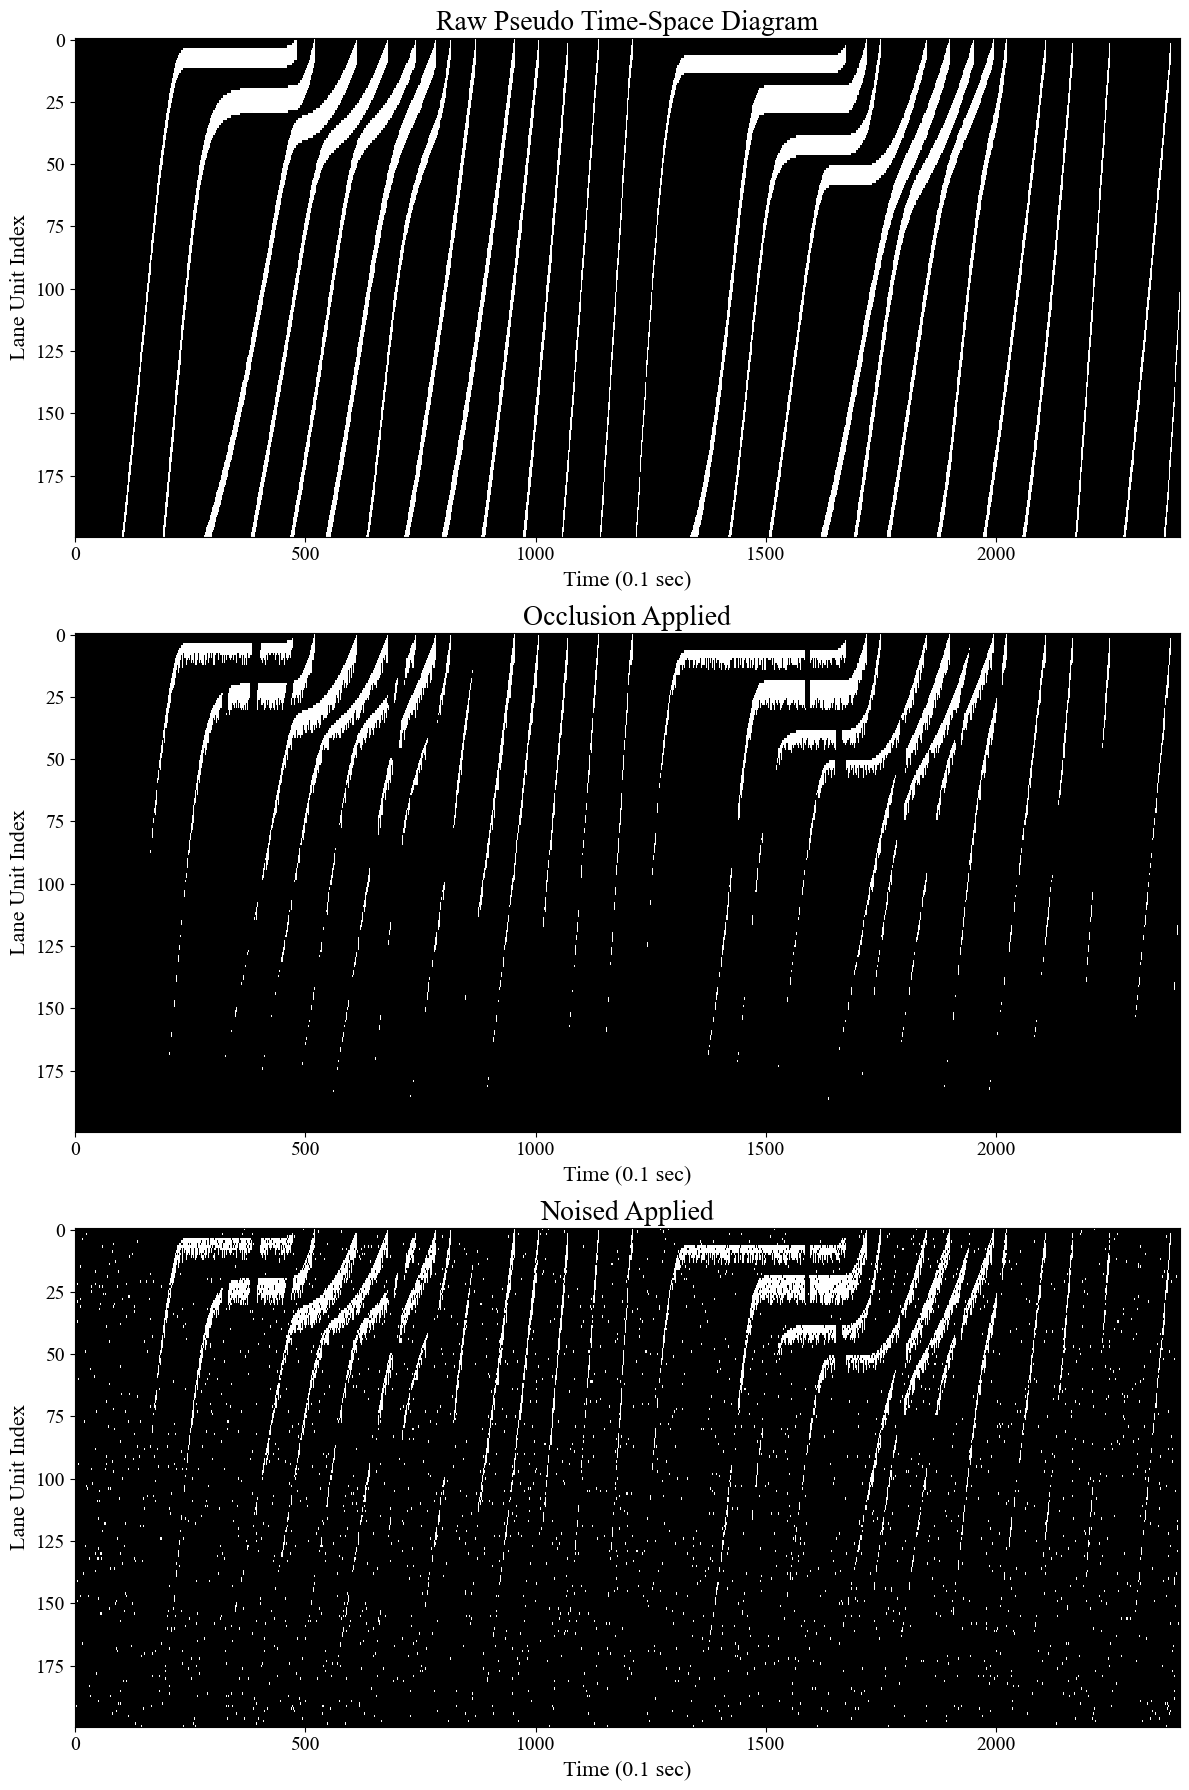

In [12]:
# set times new roman font
plt.rcParams["font.family"] = "Times New Roman"
# raw time-space diagram, occluded_diagram, noised, 3x1 grid
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
plt.imshow(time_space_mask, cmap='gray', aspect='auto', interpolation='none')
plt.title('Raw Pseudo Time-Space Diagram', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(occluded_diagram, cmap='gray', aspect='auto', interpolation='none')
plt.title('Occlusion Applied', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(noised, cmap='gray', aspect='auto', interpolation='none')
plt.title('Noised Applied', fontsize=20)
plt.xlabel('Time (0.1 sec)', fontsize=16)
plt.ylabel('Lane Unit Index', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar()
plt.tight_layout()
# plt.savefig('D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\DataAugmentation.png', dpi = 300)
plt.show()
